In [1]:
!pip install GEOparse

     |████████████████████████████████| 286kB 18.5MB/s 
  Created wheel for GEOparse: filename=GEOparse-2.0.2-cp36-none-any.whl size=28847 sha256=3c507720b566b3d2608d86434b873f7d1bc2815e4057ff8f5bb40ba87d7b7d53
  Stored in directory: /root/.cache/pip/wheels/84/6e/b8/b6497c4f50bde2c3b3f195a470e1bc894312407656896dd6bc
Successfully built GEOparse


In [2]:
import GEOparse
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelBinarizer, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, roc_auc_score
sns.set()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# path to drive
datasets_path = os.path.join('drive', 'My Drive', 'Lab 2')

Mounted at /content/drive


<h1>Load Lung Cancer Dataset</h1>

In [5]:
lung_cancer_samples = np.load( os.path.join( datasets_path, 'lung_cancer.npy' ) )
lung_cancer_labels = np.load( os.path.join( datasets_path, 'lung_cancer_labels.npy' ) ).astype(np.int32)

## Load Breast Cancer Dataset

In [5]:
breast_cancer_samples = np.load( os.path.join( datasets_path, 'breastcancer-samples.npy' ) ).astype( np.float32 )
breast_cancer_labels = np.load( os.path.join( datasets_path, 'breastcancer-labels.npy' ) ).astype( np.int32 )

## Load Colon Cancer Dataset

In [96]:
colon_cancer_samples = np.load( os.path.join( datasets_path, 'coloncancer-samples.npy' ) ).astype( np.float32 )
colon_cancer_labels = np.load( os.path.join( datasets_path, 'coloncancer-labels.npy' ) ).astype( np.int32 )

## Load bank Marketing dataset

In [4]:
# Load bank dataset

bank_samples = np.load( os.path.join( datasets_path, 'bank-data-samples.npy' ) ).astype(np.float32)
bank_labels = np.load( os.path.join( datasets_path, 'bank-data-labels.npy' ) ).astype(np.int32)

if len( bank_labels.shape ) > 1:
  bank_labels = np.squeeze( bank_labels, axis=-1 )

In [5]:
def preprocess_dataset( samples, labels ):

  scaler = MinMaxScaler()

  std = np.std( samples )

  normalized_samples = scaler.fit_transform(samples)

  positive_samples = normalized_samples[labels == 1]
  negative_samples = normalized_samples[labels == 0]

  print( len(positive_samples), ', ', len(negative_samples) )

  print('{:.2f}, {:.2f}'.format(np.min(normalized_samples), np.max(normalized_samples)))

  return normalized_samples, scaler

In [7]:
normalized_samples, min_max_scaler = preprocess_dataset(bank_samples, bank_labels)

5289 ,  39922
0.00, 1.00


In [8]:
def get_one_hot_encoding(indices, depth):

  return tf.one_hot(indices, depth)

In [9]:
def get_input_with_labels(samples, one_hot_labels):

  return tf.concat([samples, one_hot_labels], axis=1)

In [10]:
# create dataset of batches

def get_batches(buffer_size, batch_size, samples, labels):

  return tf.data.Dataset.from_tensor_slices((samples, labels)).shuffle(buffer_size).batch(batch_size)

In [12]:
BUFFER_SIZE = normalized_samples.shape[0]
BATCH_SIZE = 128

dataset = get_batches(BUFFER_SIZE, BATCH_SIZE, normalized_samples, bank_labels)

In [14]:
noise_dim = 100
n_classes = len( np.unique( bank_labels ) )
gen_input_dim = noise_dim + n_classes
output_shape = normalized_samples.shape[1]
disc_input_dim = normalized_samples.shape[1] + n_classes

In [ ]:
# MG-GAN

def mg_generator(gen_input):

  # TODO -- define the input shape of mg-GAN

  dense1 = tf.keras.layers.Dense(128, use_bias=False)(merged)
  batch_norm1 = tf.keras.layers.BatchNormalization()(dense1)
  leaky_relu_1 = tf.keras.layers.LeakyReLU()(batch_norm1)

  dense2 = tf.keras.layers.Dense(128, use_bias=False)(leaky_relu_1)
  batch_norm2 = tf.keras.layers.BatchNormalization()(dense2)
  leaky_relu_2 = tf.keras.layers.LeakyReLU()(batch_norm2)

  dense3 = tf.keras.layers.Dense(128, use_bias=False)(leaky_relu_2)
  batch_norm3 = tf.keras.layers.BatchNormalization()(dense3)
  leaky_relu_3 = tf.keras.layers.LeakyReLU()(batch_norm3)

  output = tf.keras.layers.Dense(22215, use_bias=False, activation='sigmoid')(leaky_relu_3)

  g = tf.keras.Model(inputs=[input_layer_1,input_layer_2], outputs=[output])

  return g

In [17]:
# Basic GAN

def generator_model(gen_input_dim, output_shape, hidden_units=128):

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(hidden_units, input_shape = (gen_input_dim,), use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Dense(hidden_units * 2, use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Dense(hidden_units * 4, use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Dense(output_shape, use_bias=False, activation='sigmoid'),

      # tf.keras.layers.Reshape((28,28,1))
  ])
      
  return model

In [18]:
generator = generator_model(gen_input_dim, output_shape, hidden_units=32)

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                3264      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2048      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [19]:
def discriminator_model(disc_input_dim, hidden_units=128):

  model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(disc_input_dim,)),

    tf.keras.layers.Dense(hidden_units * 4),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(hidden_units * 2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(hidden_units),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1)
  ])

  return model

In [20]:
discriminator = discriminator_model(disc_input_dim, hidden_units=32)

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               2432      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [21]:
@tf.function
def get_gradient( crit, real, fake, epsilon ):

  mixed_samples = real * epsilon + fake * (1 - epsilon)

  mixed_scores = crit( mixed_samples )

  gradient = tf.gradients(mixed_scores, mixed_samples)

  return gradient

In [22]:
# compute gradient penalty
def gradient_penalty(gradient):

  gradient_norm = tf.norm( gradient, axis=1 )

  return tf.reduce_mean(( gradient_norm - 1 ) **2 )

In [21]:
# test get_gradient

real = tf.random.normal( (BATCH_SIZE, normalized_samples.shape[1] + 2) ) + 1
fake = tf.random.normal( (BATCH_SIZE, normalized_samples.shape[1] + 2) ) - 1
epsilon_shape = [1 for _ in normalized_samples.shape]
epsilon_shape[0] = BATCH_SIZE
epsilon = tf.random.uniform(epsilon_shape)

gradient = get_gradient( discriminator, real, fake, epsilon)

<h1>Wasserstein Loss</h1>

In [23]:
# Wasserstien loss for generator

def get_gen_wloss( fake_output ):

  return - tf.reduce_mean( fake_output )

In [24]:
# Wasserstien loss for critic

def get_crit_wloss( fake_output, real_output, gp, c_lambda ):

  crit_loss = - tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)  + c_lambda * gp
  return crit_loss

In [25]:
# define the optimization algorithm for the generator and the discriminator

generator_optimizer = tf.keras.optimizers.Adam( 1e-5 )
discriminator_optimizer = tf.keras.optimizers.Adam( 1e-5 )

In [26]:
# Number of epochs
Dataset='bank marketing'
EPOCHS = 50

In [27]:
# gradient weight
c_lambda = 10

# update the weights of the critic for several times for each generator update
crit_repeats = 5

In [28]:
# Wasserstien GAN
@tf.function
def train_step(samples, one_hot_labels):

  batch_size = min(samples.shape[0], BATCH_SIZE)

  mean_crit_loss = 0
  gen_loss = 0

  for _ in range(crit_repeats):

    with tf.GradientTape() as disc_tape:

      noise = tf.random.normal([batch_size, noise_dim])
      
      gen_input = get_input_with_labels(noise, one_hot_labels)

      generated_samples = generator(gen_input, training=True)

      real_input = get_input_with_labels(samples, one_hot_labels)
      fake_input = get_input_with_labels(generated_samples, one_hot_labels)

      real_output = discriminator(real_input, training=True)
      fake_output = discriminator(fake_input, training=True)

      # Calculate Gradient Penalty
      epsilon = tf.random.uniform((batch_size, 1))
      gradient = get_gradient(discriminator, real_input, fake_input, epsilon)
      gp = gradient_penalty(gradient)

      # Calculate the Critic loss
      crit_loss = get_crit_wloss(fake_output, real_output, gp, c_lambda)

      gradients_of_discriminator = disc_tape.gradient(crit_loss, discriminator.trainable_variables)

      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      # keep track of the average critic loss in each batch 
      mean_crit_loss += crit_loss / crit_repeats

  with tf.GradientTape() as gen_tape:
      
      noise_2 = tf.random.normal([batch_size, noise_dim])
      
      gen_input_2 = get_input_with_labels(noise_2, one_hot_labels)

      generated_samples_2 = generator(gen_input_2, training=True)

      fake_input_2 = get_input_with_labels(generated_samples_2, one_hot_labels)

      fake_output_2 = discriminator(fake_input_2, training=True)

      gen_loss = get_gen_wloss(fake_output_2)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
  return gen_loss,mean_crit_loss

In [29]:
def train(dataset, epochs):

  gen_losses = []
  disc_losses = []

  for epoch in range(epochs):
    
    gen_loss_step = []
    disc_loss_step = []

    # if  epoch == 0 or (epoch + 1) % 50 == 0 :

    print( 'training GAN - epoch ----> ', epoch+1)

    # Save the model every 500 epochs
    #if (epoch + 1) % 500 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    for batch, batch_labels in dataset:

    #  if epoch == 0 or (epoch + 1) % 50 == 0:
        
      gen_loss,crit_loss = train_step(batch, get_one_hot_encoding(batch_labels, depth=2))

      gen_loss_step.append( gen_loss )
      disc_loss_step.append( crit_loss )

    #  else:
    #    train_step(batch, get_one_hot_encoding(batch_labels, depth=2))

    # if  epoch == 0 or (epoch + 1) % 50 == 0 :

    gen_losses.append( np.average( gen_loss_step ) )
    disc_losses.append( np.average( disc_loss_step ) )

    print('generator loss: {:.3f}, discriminator loss: {:.3f}'.format(
        np.average(gen_loss_step),
        np.average(disc_loss_step)
    ))

  return gen_losses, disc_losses

In [30]:
genlosses, disc_losses = train( dataset, EPOCHS )

training GAN - epoch ---->  1
generator loss: 0.067, discriminator loss: 0.044
generator loss: 0.050, discriminator loss: -0.082
generator loss: -0.004, discriminator loss: -0.104
generator loss: -0.089, discriminator loss: -0.107
generator loss: -0.088, discriminator loss: -0.128
generator loss: -0.054, discriminator loss: -0.148
generator loss: -0.038, discriminator loss: -0.156
generator loss: -0.045, discriminator loss: -0.141
generator loss: 0.010, discriminator loss: -0.138
generator loss: 0.060, discriminator loss: -0.152
generator loss: 0.063, discriminator loss: -0.151
generator loss: 0.083, discriminator loss: -0.147
generator loss: 0.079, discriminator loss: -0.144
generator loss: 0.022, discriminator loss: -0.155
generator loss: -0.036, discriminator loss: -0.154
generator loss: -0.068, discriminator loss: -0.136
generator loss: -0.098, discriminator loss: -0.111
generator loss: -0.097, discriminator loss: -0.105
generator loss: -0.111, discriminator loss: -0.112
generator 

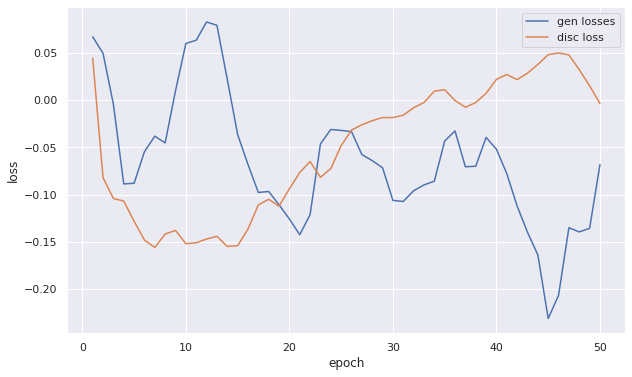

In [31]:
# x_ticks = [x*50 for x in list(range(EPOCHS // 50 +1))]
x_ticks = list(range(1, EPOCHS + 1))
plt.figure(figsize=(10,6))
plt.plot(x_ticks,genlosses)
plt.plot(x_ticks,disc_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['gen losses','disc loss'], loc='upper right')
plt.savefig('generator loss - discriminator loss - {} - {} epochs.png'.format(Dataset, EPOCHS))
plt.show()

In [32]:
def generate_samples(model,num_examples_to_generate, Class):

  labels = np.array([])

  if Class == 1:
    labels = np.ones(num_examples_to_generate)
  elif Class == 0:
    labels = np.zeros(num_examples_to_generate)

  seed = tf.random.normal([num_examples_to_generate,noise_dim])

  one_hot_encoded_labels = get_one_hot_encoding(labels, depth=2)

  gen_input = get_input_with_labels(seed, one_hot_encoded_labels)

  # model is refering generator
  synthetic_samples = model(gen_input, training = False)

  return synthetic_samples, labels, one_hot_encoded_labels

In [33]:
# load x_train, y_train, x_test, y_test

x_train = np.load( os.path.join(datasets_path, 'bank-data_x_train.npy') )
y_train = np.load( os.path.join(datasets_path, 'bank-data_y_train.npy') )
x_test = np.load( os.path.join(datasets_path, 'bank-data_x_test.npy') )
y_test = np.load( os.path.join(datasets_path, 'bank-data_y_test.npy') )

print( 'Class 0 = {}, Class 1 = {}'.format( len( y_train[y_train==0] ), len(y_train[y_train==1]) ) )

Class 0 = 31923, Class 1 = 4245


In [34]:
synthetic_samples_1,synthetic_labels_1, one_hot_encoded_labels = generate_samples(
    generator,
   num_examples_to_generate=27680, Class=1)

synthetic_samples_0,synthetic_labels_0, one_hot_encoded_labels = generate_samples(
    generator,
   num_examples_to_generate=2, Class=0)

synthetic_samples = np.concatenate((synthetic_samples_0, synthetic_samples_1), axis=0)
synthetic_labels = np.concatenate((synthetic_labels_0, synthetic_labels_1))
print(synthetic_samples_0.shape, synthetic_labels_0.shape)
print(synthetic_samples_1.shape, synthetic_labels_1.shape)

(2, 16) (2,)
(27680, 16) (27680,)


In [35]:
augmented_x_train = np.concatenate(( x_train, synthetic_samples_0, synthetic_samples_1 ), axis=0)
augmented_y_train = np.concatenate(( y_train, synthetic_labels_0, synthetic_labels_1 ), axis=0)

In [36]:
print('# of samples belonging to class 1: {}, and class 0: {}'.format(
    len(augmented_y_train[augmented_y_train == 1]),
    len(augmented_y_train[augmented_y_train == 0]))
)

# of samples belonging to class 1: 31925, and class 0: 31925


In [37]:
skfold = StratifiedKFold( n_splits=5 )

lr = LogisticRegressionCV( cv=skfold, max_iter=3000 )

lr.fit( augmented_x_train, augmented_y_train )

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=3000, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [39]:
# Decision Tree Classifier

params = { 'max_depth': list( range( 5, 31 ) )+[None] }

decision_tree = DecisionTreeClassifier()

gridSearchCV = GridSearchCV(estimator=decision_tree ,param_grid=params, cv=skfold )

gridSearchCV.fit( augmented_x_train, augmented_y_train )

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
     

In [41]:
# K-Nearest Neighbors

knn = KNeighborsClassifier()

params = { 'n_neighbors': list( range( 5, 16 ) ) }

gridSearchCV = GridSearchCV(
    estimator=knn,
    param_grid=params,
    cv=skfold
)

gridSearchCV.fit( augmented_x_train, augmented_y_train )

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
# scores ----> accuracy, recall, precision, roc_auc, confusion matrix

best_estimator_ = gridSearchCV.best_estimator_

y_pred = best_estimator_.predict( x_test )

# recall
print( 'recall = {}'.format( recall_score(y_test, y_pred) ) )

# precision
print( 'precision = {}'.format( precision_score(y_test, y_pred) ) )

# accuracy
print( 'accuracy = {}'.format( accuracy_score( y_test, y_pred ) ) )

# roc_auc
print( 'roc_auc = {}'.format( roc_auc_score( y_test, y_pred ) ) )

# confusion matrix
print( confusion_matrix(y_test, y_pred) )

recall = 0.18295019157088122
precision = 0.5120643431635389
accuracy = 0.885546831803605
roc_auc = 0.5800986737326841
[[7817  182]
 [ 853  191]]


In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(augmented_x_train, augmented_y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### The Generator works on maximizing the critic's mean prediction on the fake ouput ----> the gen's loss will the be negative of the critic's prediction